Note: Much of this code was lifted from [the Conversation AI project](https://conversationai.github.io/). In this file, instead of using max DI I want to do each of the DIs against gay and basically plot a bunch of lines on the same axis, di of input and di of output but one line for white, one line for black, one line for jewish etc

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # feel free to comment this line out if not using retina screen

Read TSVs from file. These are the original data from *Conversation AI*.

* *grouped_annotations* takes the mean of all toxicity ratings of a comment.
* *joined_tox* joins *grouped_annotations* and *comments*.
* We also add a column *binary_tox* to the dataframe *joined_tox*. Here we assign a toxicity rating of 0 or 1 based on whether the mean toxicity rating is above or below 0.5 (or other value determined by threshold_binary_toxicity

Equation DI:
DI(t1,t2) = (probability that comment containing term t1 is labeled toxic) / (probability that comment containing term t2 is labelled toxic)
= a/b

a = # comments containing t1 AND toxic / # comments containing t1
= alpha/beta

In [2]:
def calculate_pairwise_di(df, madlibs_terms, colname):
    
    # We now calculate the DI for each pair for the training data.

    term_toxicity = np.zeros(len(madlibs_terms))

    # we temporarily put -1 in as a placeholder for stuff that has no exacmples of terms with that term.
    # non-binary is one
    for i in range(len(madlibs_terms)):
        try:
            term_toxicity[i] = float((df[(df[madlibs_terms[i]] == True) & (df[colname] == 1)].shape[0]))/  \
            float((df[df[madlibs_terms[i]] == True].shape[0]))
        except ZeroDivisionError:
            term_toxicity[i] = -1 

    return term_toxicity

# term_toxicity = calculate_pairwise_di(train_comments, madlibs_terms, 'binary_tox')
# print(term_toxicity)
# print(len(term_toxicity))


In [3]:
# This finds the max DI between all pairs of identity terms, which for one of our experiments,
# we're claiming is kind of the DI of all terms
# Possibly something we'll take out or come back to once we try more versions of our code. (Neha's working on this!)

def gay_ratio(term_toxicity, madlibs_terms):
    term_vs_gay = []
    top_indexes = ()
    j = 0 # This is the index of gay
    for i in range(len(madlibs_terms)):
        if (i==j or term_toxicity[i] == -1 or term_toxicity[j] == -1 or term_toxicity[j] == 0):
            term_vs_gay.append(1)
        else:
            term_vs_gay.append(term_toxicity[i]/ term_toxicity[j])          
    return term_vs_gay

In [4]:
# Calculate max DIs on all of the perturbed training datasets
def find_gay_dis(df_comments, madlibs_terms, colname):
    
    term_vs_gay = []
    # So this is a series of DIs, one is t1/gay di, t2/gay di...

    # df_comments['newcol'] = list_perturbation[i]
    term_toxicity = calculate_pairwise_di(df_comments, madlibs_terms, colname)
    term_vs_gay = gay_ratio(term_toxicity, madlibs_terms)
        
    # This is the array of all of the max_dis, and the indexes of the madlibs_terms array that composed that max_di
    return term_vs_gay

In [25]:
def train_and_predict(train_comments, test_comments, i):

#     # This trains a classifier on n different perturbed datsets
#     d={}
#     for x in range(NUM_PERTURBATIONS):
#         d["clf{0}".format(x)] = Pipeline([
#             ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
#             ('tfidf', TfidfTransformer(norm = 'l2')),
#             ('clf', LogisticRegression()),
#         ])
#         d["clf{0}".format(x)] = d["clf{0}".format(x)].\
#                                     fit(train_comments['comment'], list_perturbations_training[x])
#         d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
#                                     d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
#         print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
#     # Once a classifier is trained, this goes to the test data and creates predictions on test data
#     perturbed_predictions = [] # list, each item is array of predictions. element 0 is 0th perturbation and 
#     # predictions based on that.
#     # each item in the array is a column that indicates 0/1 for predicted not-toxic/toxic

#     for i in range(NUM_PERTURBATIONS):
#         perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
#     return perturbed_predictions

    clf = Pipeline([
        ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
        ('tfidf', TfidfTransformer(norm = 'l2')),
        ('clf', LogisticRegression()),
    ])

    clf = clf.fit(train_comments['comment'], train_comments['binary_tox'])
    auc = roc_auc_score(test_comments['binary_tox'], clf.predict_proba(test_comments['comment'])[:, 1])
    print('Test ROC AUC: %.3f' %auc)
    
    test_comments["predicted"+str(i)] = clf.predict(test_comments['comment'])
    
    return test_comments

That cell below takes a really long time to run

In [88]:
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']
array_of_train_dis = []
array_of_test_dis = []
array_predicted_bin_tox = []
array_test_bin_tox = []

#TODO: This code is really unnecessarily complicated, you could instead have a dictionary of dataframes and store all
for i in range(30,95,5):
# for i in range(30,40,5):
    joined_tox = pd.read_csv('joined_tox' + str(i) + '.csv')
    train_comments = pd.read_csv('train_comments'+ str(i) + '.csv')
    test_comments = pd.read_csv('test_comments' + str(i) + '.csv')
    # madlibs_terms = model_bias_analysis.read_identity_terms('test_comments'+str(i)+'.csv')
    
    training_data_dis = find_gay_dis(train_comments, madlibs_terms, 'binary_tox')
    print(str(i), training_data_dis)
    array_of_train_dis.append((i,training_data_dis))
    
    test_comments = train_and_predict(train_comments, test_comments,str(i))
    
    temp_array = []
    temp_array = test_comments['predicted'+str(i)]
    array_predicted_bin_tox.append(temp_array)
    
    temp_array = []
    temp_array = test_comments['binary_tox']
    array_test_bin_tox.append(temp_array)
    
    test_data_dis = find_gay_dis(test_comments, madlibs_terms, 'predicted'+str(i))
    print(str(i), test_data_dis)
    array_of_test_dis.append((i, test_data_dis))

30 [1, 0.8863430810973771, 0.37764638565706665, 0.4076357128653808, 0.3315111973196967, 0.2503615469544529, 0.3551835548713056, 0.2745952193094558]
Test ROC AUC: 0.918
30 [1, 0.8425760286225403, 0.3087512291052114, 0.27799911465250116, 0.24236605293874017, 0.17018970189701899, 0.24326485729994501, 0.18063773833004604]
35 [1, 0.7782363345405542, 0.29839612085042894, 0.3733125937447919, 0.30149268436868815, 0.19097848233796585, 0.2713950797525943, 0.23209966998134135]
Test ROC AUC: 0.939
35 [1, 0.7577885037297061, 0.22282517949574224, 0.23603698413891605, 0.21531875987033497, 0.1300506212609296, 0.15590863952333664, 0.13982715397809736]
40 [1, 0.7802736024320216, 0.2991772625280479, 0.37206193605881693, 0.3022819322335276, 0.19147842600900766, 0.27210553807655397, 0.2327072607404548]
Test ROC AUC: 0.939
40 [1, 0.6888986397542782, 0.22282517949574224, 0.23603698413891605, 0.21531875987033497, 0.1300506212609296, 0.15590863952333664, 0.13982715397809736]
45 [1, 0.7612903225806452, 0.219241

In [92]:
test_comments['temp'] = array_test_bin_tox[10]
test_comments['temp'].value_counts()
#test_comments[(test_comments['gay'] == True) & (test_comments['temp'] == 1)].shape[0]

0    29904
1     1962
Name: temp, dtype: int64

In [ ]:
# Ugh something seems wrong, must check now -_-

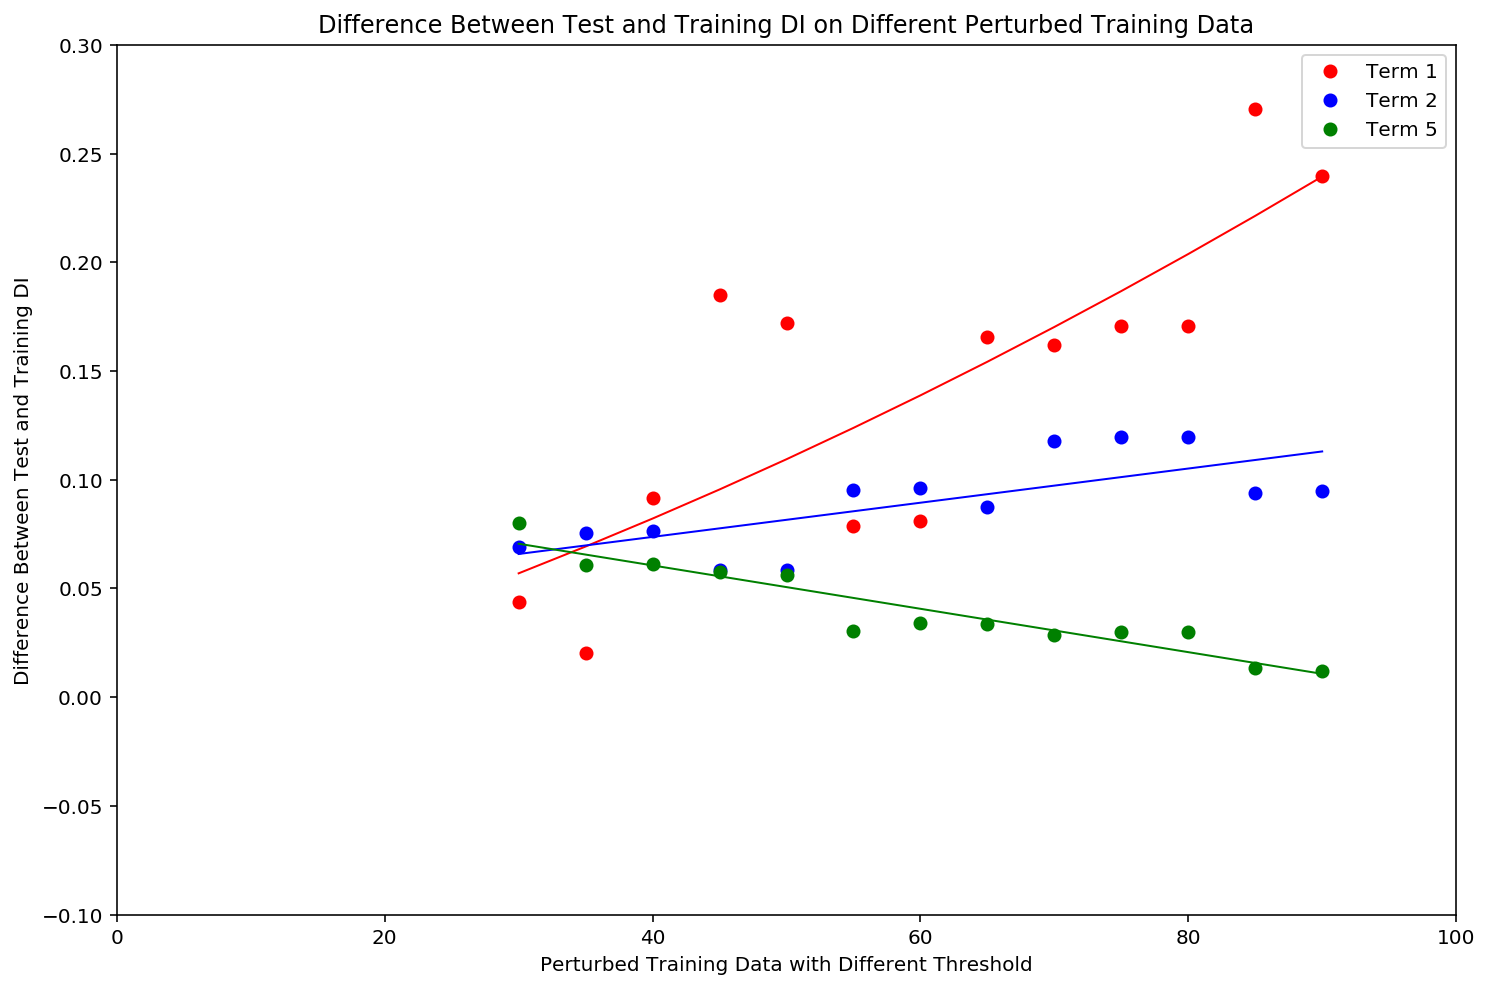

In [89]:
# A graph of the difference between test and training DI on y axis and x axis of threshold
# for t1/gay
x_axis = []
y_axis_t1 = []
plt.figure(figsize=(12, 8))


for i in range(30,95,5):
    x_axis.append(i)

y_axis_t1 = []
y_axis_t2 = []
y_axis_t5 = []
for i in range(len(array_of_test_dis)):
    training_di = array_of_train_dis[i][1][1]
    test_di = array_of_test_dis[i][1][1]
    y_axis_t1.append(training_di - test_di)
    y_axis_t2.append(array_of_train_dis[i][1][2] - array_of_test_dis[i][1][2])
    y_axis_t5.append(array_of_train_dis[i][1][5] - array_of_test_dis[i][1][5])
line1, = plt.plot(x_axis, y_axis_t1, "ro", label='Term 1')
line2, = plt.plot(x_axis, y_axis_t2, "bo", label='Term 2')
line3, = plt.plot(x_axis, y_axis_t5, "go", label='Term 5')
plt.xlim([0, 100])
plt.ylim([-0.1, .3])
plt.title("Difference Between Test and Training DI on Different Perturbed Training Data")
plt.xlabel("Perturbed Training Data with Different Threshold")
plt.ylabel("Difference Between Test and Training DI")
plt.legend(handles=[line1, line2, line3])


# x = np.array(x_axis).reshape(-1, 1)
x2 = np.asarray(x_axis)
x2 = np.multiply(x2.T, x2)
X = np.concatenate((x_axis,x2),axis=0)
X = X.reshape(2,len(x2))
reg1 = linear_model.LinearRegression()
reg1.fit(X.T, y_axis_t1)
y_pred1 = reg1.predict(X.T)
plt.plot(x, y_pred1, color='r', linewidth=1)

reg2 = linear_model.LinearRegression()
reg2.fit(x, y_axis_t2)
y_pred2 = reg2.predict(x)
plt.plot(x, y_pred2, color='b', linewidth=1)

reg3 = linear_model.LinearRegression()
reg3.fit(x, y_axis_t5)
y_pred3 = reg3.predict(x)
plt.plot(x, y_pred3, color='g', linewidth=1)

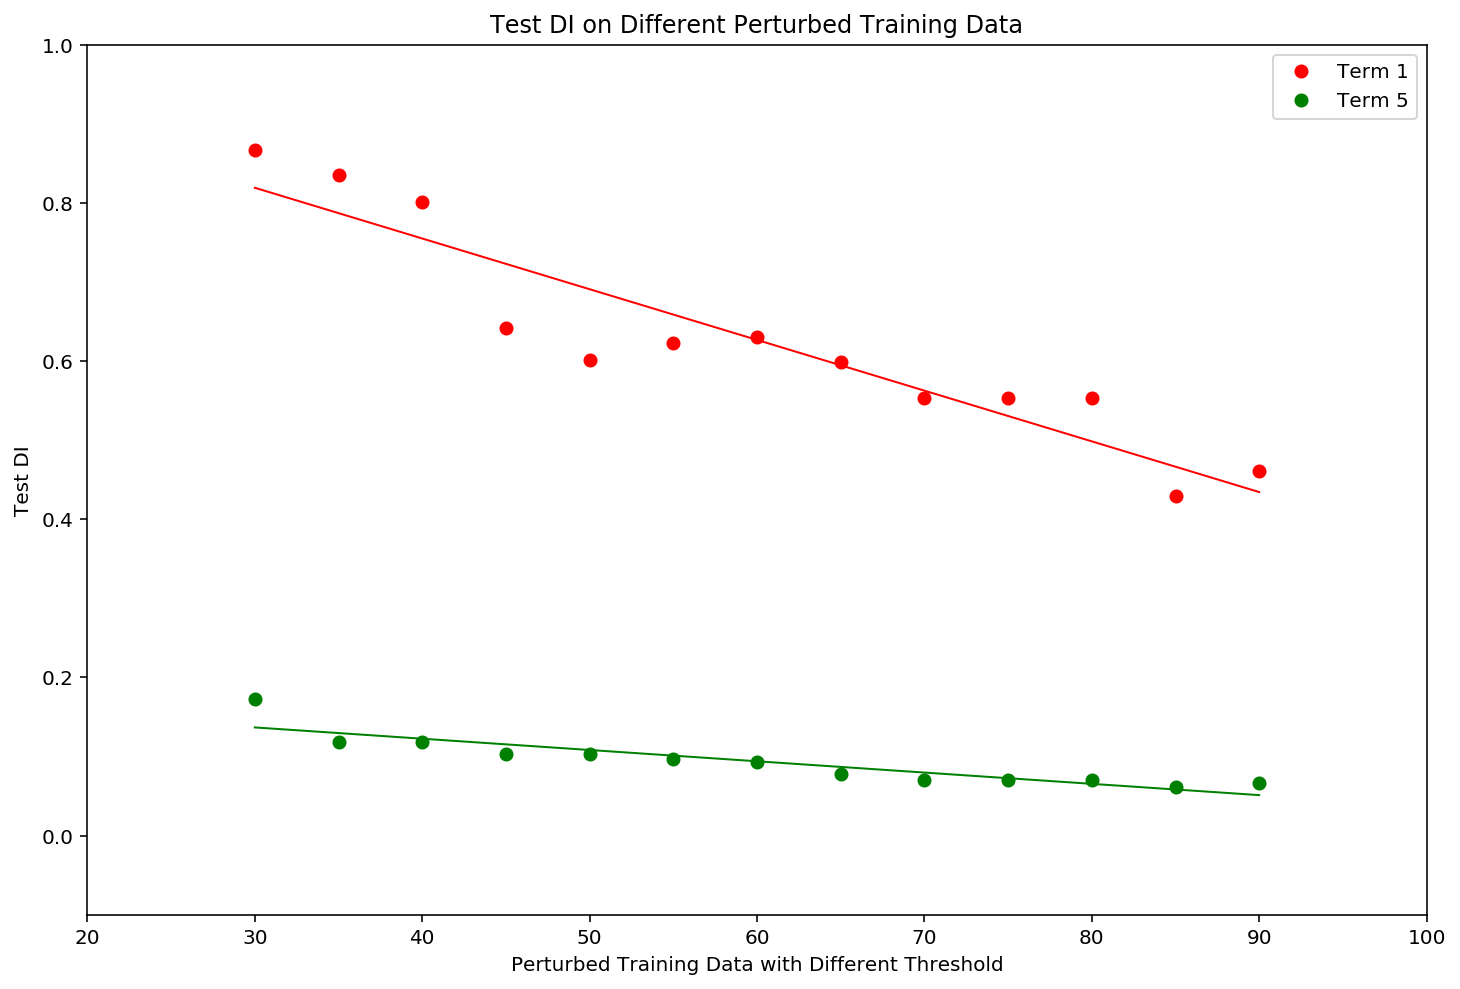

In [63]:
y_axis_t1 = []
y_axis_t5 = []
plt.figure(figsize=(12, 8))


for i in range(len(array_of_test_dis)):
    y_axis_t1.append(array_of_test_dis[i][1][1])
    y_axis_t5.append(array_of_test_dis[i][1][5])
line1, = plt.plot(x_axis, y_axis_t1, "ro", label='Term 1')
line2, = plt.plot(x_axis, y_axis_t5, "go", label='Term 5')
plt.title("Test DI on Different Perturbed Training Data")
plt.xlabel("Perturbed Training Data with Different Threshold")
plt.ylabel("Test DI")
plt.xlim([20, 100])
plt.ylim([-0.1, 1])
plt.legend(handles=[line1, line2])

x = np.array(x_axis).reshape(-1, 1)
reg1 = linear_model.LinearRegression()
reg1.fit(x, y_axis_t1)
y_pred1 = reg1.predict(x)
plt.plot(x, y_pred1, color='r', linewidth=1)

reg2 = linear_model.LinearRegression()
reg2.fit(x, y_axis_t5)
y_pred2 = reg2.predict(x)
plt.plot(x, y_pred2, color='g', linewidth=1)

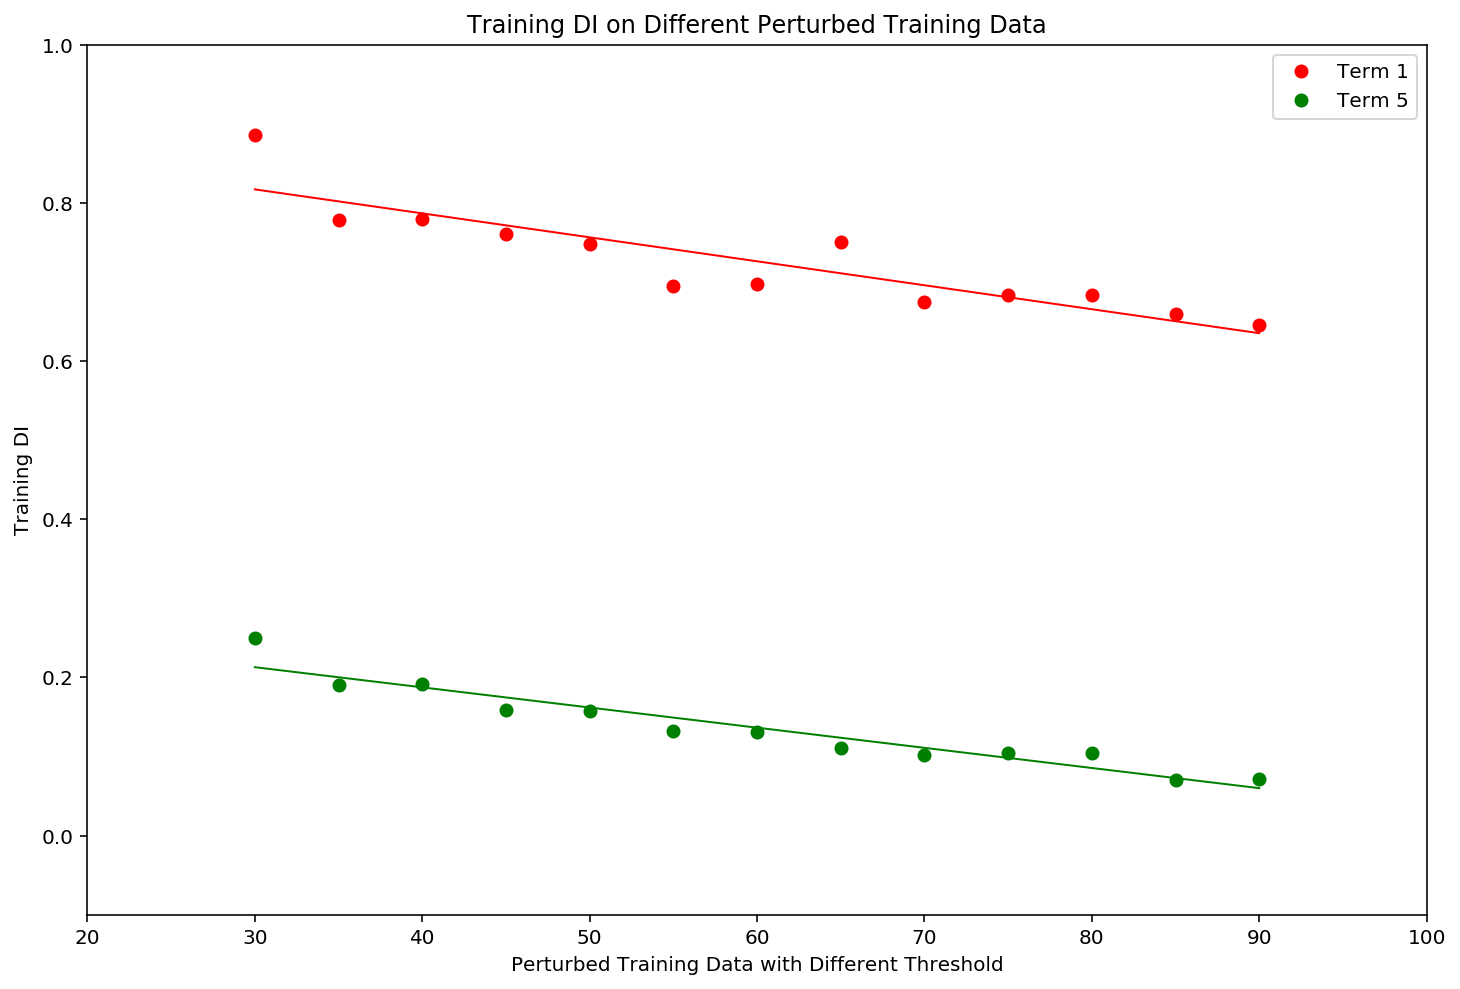

In [64]:
y_axis_t1 = []
y_axis_t5 = []
plt.figure(figsize=(12, 8))



for i in range(len(array_of_test_dis)):
    y_axis_t1.append(array_of_train_dis[i][1][1])
    y_axis_t5.append(array_of_train_dis[i][1][5])
line1, = plt.plot(x_axis, y_axis_t1, "ro", label='Term 1')
line2, = plt.plot(x_axis, y_axis_t5, "go", label='Term 5')
plt.title("Training DI on Different Perturbed Training Data")
plt.xlabel("Perturbed Training Data with Different Threshold")
plt.ylabel("Training DI")
plt.xlim([20, 100])
plt.ylim([-0.1, 1])
plt.legend(handles=[line1, line2])

x = np.array(x_axis).reshape(-1, 1)
reg1 = linear_model.LinearRegression()
reg1.fit(x, y_axis_t1)
y_pred1 = reg1.predict(x)
plt.plot(x, y_pred1, color='r', linewidth=1)

reg2 = linear_model.LinearRegression()
reg2.fit(x, y_axis_t5)
y_pred2 = reg2.predict(x)
plt.plot(x, y_pred2, color='g', linewidth=1)

In [65]:
test_comments['temp'] = array_predicted_bin_tox[0]
test_comments.head()

,Unnamed: 0,rev_idrev_id,toxicity,rev_idrev_id.1,comment,year,logged_in,ns,sample,split,...,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed,predicted90,temp
0,2,8953.0,0.0,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,...,False,False,False,False,False,False,False,False,0,0
1,4,28959.0,0.2,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,...,False,False,False,False,False,False,False,False,0,0
2,19,138074.0,0.0,138074.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLIN...,2002,True,article,random,test,...,False,False,False,False,False,False,False,False,0,0
3,33,200664.0,0.0,200664.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKEN NEWLIN...,2002,True,user,random,test,...,False,False,False,False,False,False,False,False,0,0
4,37,213105.0,0.0,213105.0,`NEWLINE_TOKENNEWLINE_TOKEN: I should do that ...,2002,True,user,random,test,...,False,False,False,False,False,False,False,False,0,0


x_axis:  [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
num_comments_gay 155
num_gay_and_toxic 115
num_gay_and_toxic 106
num_gay_and_toxic 106
num_gay_and_toxic 92
num_gay_and_toxic 92
num_gay_and_toxic 83
num_gay_and_toxic 82
num_gay_and_toxic 74
num_gay_and_toxic 60
num_gay_and_toxic 60
num_gay_and_toxic 60
num_gay_and_toxic 43
num_gay_and_toxic 40


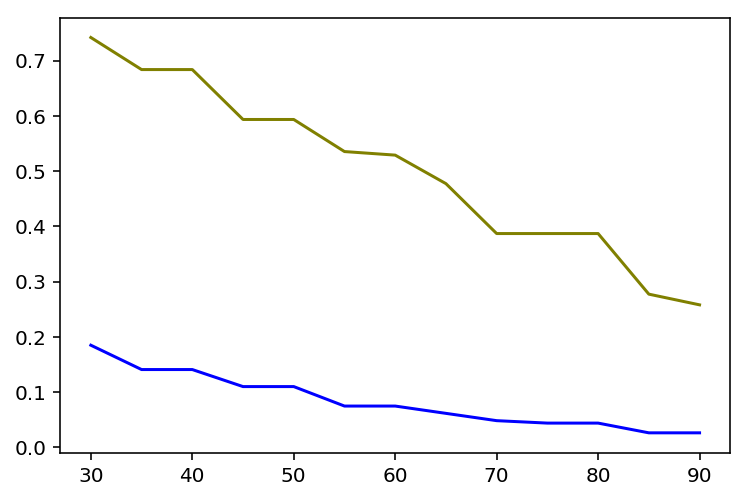

In [67]:
# Curious about the literal probability that gay (and white) sis classified as toxic changing as threshold changes
print("x_axis: ", x_axis)
num_of_comments_gay = test_comments[test_comments['gay'] == True].shape[0]
num_of_comments_white = test_comments[test_comments[''] == True].shape[0]
print("num_comments_gay", num_of_comments_gay)white
gay_toxic_prob = []
num_gay_and_toxic = []
white_toxic_prob = []
for i in range(len(array_predicted_bin_tox)):
    test_comments['temp'] = array_predicted_bin_tox[i]
    test_comments.head()
    num_gay_and_toxic = test_comments[(test_comments['gay'] == True) & (test_comments['temp'] == 1)].shape[0]
    num_white_and_toxic = test_comments[(test_comments['white'] == True) & (test_comments['temp'] == 1)].shape[0]
    print("num_gay_and_toxic", num_gay_and_toxic)
    gay_toxic_prob.append(num_gay_and_toxic/num_of_comments_gay)
    white_toxic_prob.append(num_white_and_toxic/num_of_comments_white)
plt.plot(x_axis, gay_toxic_prob, color='olive')
plt.plot(x_axis, white_toxic_prob, color='blue')

In [70]:
# Also curious about the FPR/TPR of gay as threshold changes
# fpr = false positive / false positive + true negative = false positive / total negative

# This requires an assumption about what ground truth is. What should it be? The 50% threshold val? The x% threshold val? 
# We are assuming it is the same as the threshold

for i in range(len(array_test_bin_tox)):
    # the "true" value is in array_test_bin_tox
    # the predicted value is in array_predicted_bin_tox
    

test_comments['temp'] = array_test_bin_tox[10]
test_comments['temp'].value_counts()

0    28249
1     3617
Name: binary_tox, dtype: int64

** 0
0.9316239316239316
0.9024390243902439
0.65
0.8548387096774194
0.029184907233687718 -0.20483870967741935
** 1
0.9245283018867925
0.8787878787878788
0.7254901960784313
0.8917525773195877
0.045740423098913685 -0.16626238124115633
** 2
0.9339622641509434
0.8787878787878788
0.7647058823529411
0.8917525773195877
0.055174385363064626 -0.12704669496664656
** 3
0.9157894736842105
0.88
0.7741935483870968
0.9108910891089109
0.03578947368421048 -0.13669754072181417
** 4
0.9157894736842105
0.88
0.7741935483870968
0.9108910891089109
0.03578947368421048 -0.13669754072181417
** 5
0.9156626506024096
0.9411764705882353
0.7702702702702703
0.9095238095238095
-0.025513819985825692 -0.13925353925353923
** 6
0.9036144578313253
0.9411764705882353
0.7702702702702703
0.9095238095238095
-0.03756201275690996 -0.13925353925353923
** 7
0.8933333333333333
1.0
0.8170731707317073
0.9481132075471698
-0.10666666666666669 -0.1310400368154625
** 8
0.9122807017543859
0.9166666666666666
0.81
0.9534883720930233
-0.00438

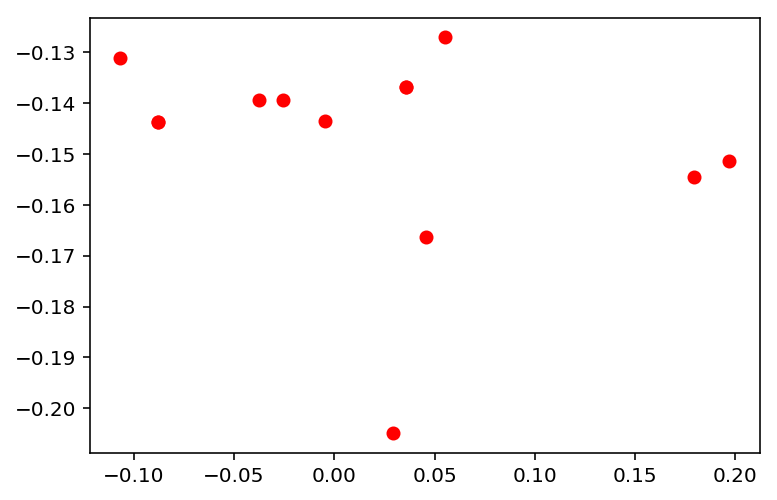

In [99]:
# Try the predictive parity equation here. -_- 
#for i in range(len(array_test_bin_tox)):
    # doing it for gay and white
    # p(predicted = 1 given "true" = 1 and comment about gay)
    # = (predicted = 1 and true = 1 and comment about gay)/(predicted =1 and comment gay)
    
i = 4
# thats the index for 50
arrayX = []
arrayY = []
for i in range(len(array_test_bin_tox)):
    test_comments['tempTrue'] = array_test_bin_tox[i]
    test_comments['tempPred'] = array_predicted_bin_tox[i]
    gay_predicted1_true1 = test_comments[(test_comments['gay'] == True) & \
                                         (test_comments['tempTrue'] == 1) & \
                                         (test_comments['tempPred'] == 1)].shape[0]
    gay_pred1 = test_comments[(test_comments['gay'] == True) & (test_comments['tempPred'] == 1)].shape[0]

    white_predicted1_true1 = test_comments[(test_comments['white'] == True) & \
                                         (test_comments['tempTrue'] == 1) & \
                                         (test_comments['tempPred'] == 1)].shape[0]
    white_pred1 = test_comments[(test_comments['white'] == True) & (test_comments['tempPred'] == 1)].shape[0]

    gay_pred0_true0 = test_comments[(test_comments['gay'] == True) & \
                                         (test_comments['tempTrue'] == 0) & \
                                         (test_comments['tempPred'] == 0)].shape[0]

    gay_pred0 = test_comments[(test_comments['gay'] == True) & (test_comments['tempPred'] == 0)].shape[0]

    white_predicted0_true0 = test_comments[(test_comments['white'] == True) & \
                                         (test_comments['tempTrue'] == 0) & \
                                         (test_comments['tempPred'] == 0)].shape[0]
    white_pred0 = test_comments[(test_comments['white'] == True) & (test_comments['tempPred'] == 0)].shape[0]

    print("**", i)
    print((gay_predicted1_true1/gay_pred1))
    print((white_predicted1_true1/white_pred1))
    print((gay_pred0_true0/gay_pred0))
    print((white_predicted0_true0/white_pred0))
    diffPred1True1 = (gay_predicted1_true1/gay_pred1) - (white_predicted1_true1/white_pred1)
    diffPred0True0 = (gay_pred0_true0/gay_pred0) - (white_predicted0_true0/white_pred0)
    print(diffPred1True1, diffPred0True0)
    
    arrayX.append(diffPred1True1)
    arrayY.append(diffPred0True0)
    
plt.plot(arrayX, arrayY, "ro")

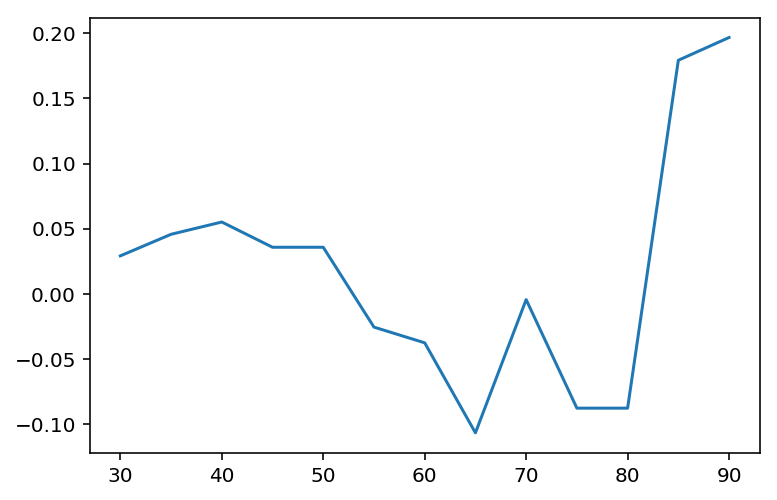

In [97]:
plt.plot(x_axis, arrayX)

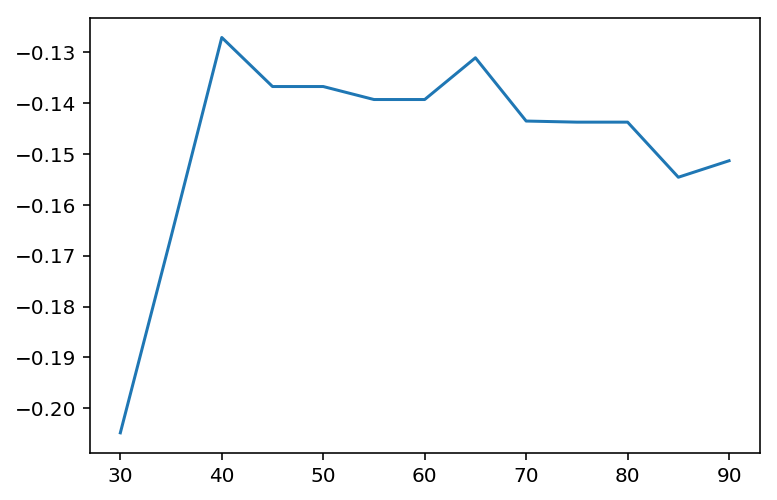

In [98]:
plt.plot(x_axis, arrayY)